# MIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Learning Objectives

1. Fit the **MIKH** model to LAOS data (nonlinear oscillatory response)
2. Analyze **Lissajous figures** (stress vs strain loops)
3. Extract **harmonic content** from the stress response
4. Understand the role of **plasticity** and **thixotropy** in nonlinear oscillatory response
5. Compare response at different frequencies

## Prerequisites

- NB01: MIKH Flow Curve (parameter understanding)
- NB05: MIKH SAOS (linear viscoelastic baseline)

## Runtime

- Fast demo: ~4-5 minutes
- Full run: ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import rfft, rfftfreq

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_pnas_laos,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


81

## 2. Theory: LAOS in Thixotropic Materials

Large Amplitude Oscillatory Shear (LAOS) probes the **nonlinear** viscoelastic and viscoplastic response.

### Applied Deformation

$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

where $\gamma_0 > \gamma_{yield}$ (large enough to induce plastic flow).

### Nonlinear Stress Response

The stress response contains **odd harmonics**:
$$
\sigma(t) = \sum_{n=1,3,5,...} [\sigma_n' \sin(n\omega t) + \sigma_n'' \cos(n\omega t)]
$$

### Key Nonlinear Features in MIKH

1. **Plastic yielding**: Distorts sinusoidal stress response
2. **Kinematic hardening**: Creates asymmetry in strain-stress loops
3. **Thixotropic restructuring**: Amplitude/frequency-dependent structure

### Lissajous Figures

Plotting $\sigma$ vs $\gamma$ reveals:
- **Ellipse**: Linear viscoelastic (SAOS)
- **Distorted ellipse**: Nonlinear viscoelastic
- **Rectangular**: Yield stress dominated

### Harmonic Analysis

The **third harmonic ratio** $I_3/I_1$ quantifies nonlinearity:
- $I_3/I_1 \to 0$: Linear response
- $I_3/I_1 > 0$: Nonlinear (strain stiffening or softening)

## 3. Load Data

We load LAOS data from the PNAS Digital Rheometer Twin dataset at $\omega = 1$ rad/s.

In [3]:
# Load LAOS data at omega = 1 rad/s, medium amplitude
omega = 1.0
strain_amp_idx = 8  # Medium-large amplitude

t_data, strain_data, stress_data = load_pnas_laos(omega=omega, strain_amplitude_index=strain_amp_idx)

# Estimate strain amplitude from data
gamma_0 = np.max(np.abs(strain_data))

print(f"LAOS data loaded:")
print(f"  omega = {omega} rad/s")
print(f"  gamma_0 = {gamma_0:.4f} (estimated)")
print(f"  Points: {len(t_data)}")
print(f"  Time range: [{t_data.min():.3f}, {t_data.max():.2f}] s")
# In FAST_MODE, subsample to 200 points to reduce ODE solve cost
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
if FAST_MODE and len(t_data) > 200:
    indices = np.linspace(0, len(t_data) - 1, 200, dtype=int)
    t_data = t_data[indices]
    strain_data = strain_data[indices]
    stress_data = stress_data[indices]
    print(f"  FAST_MODE: subsampled to {len(t_data)} points")


LAOS data loaded:
  omega = 1.0 rad/s
  gamma_0 = 3.1599 (estimated)
  Points: 1000
  Time range: [0.005, 66.00] s
  FAST_MODE: subsampled to 200 points


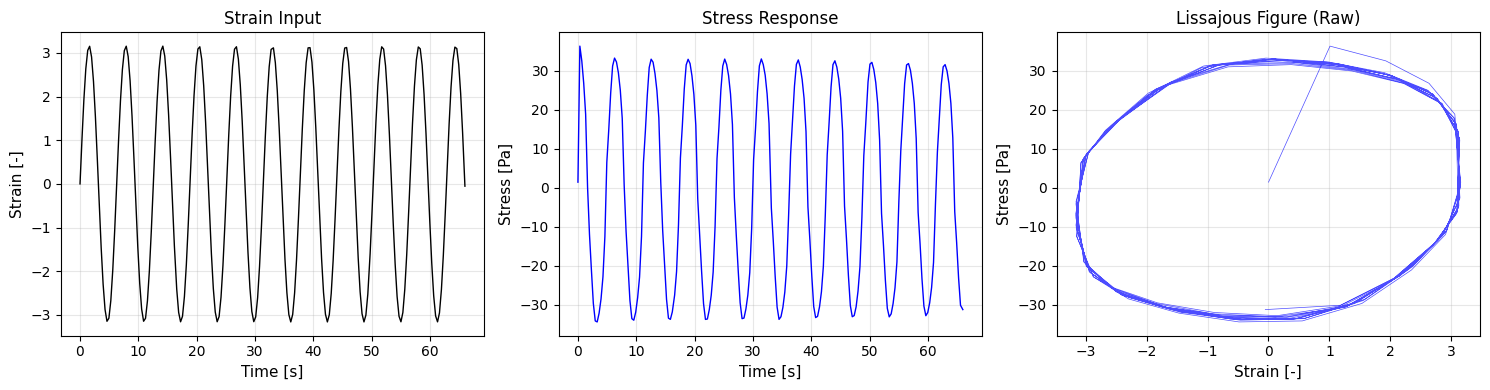

In [4]:
# Plot raw LAOS data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time series - strain
axes[0].plot(t_data, strain_data, "k-", lw=1)
axes[0].set_xlabel("Time [s]", fontsize=11)
axes[0].set_ylabel("Strain [-]", fontsize=11)
axes[0].set_title("Strain Input", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Time series - stress
axes[1].plot(t_data, stress_data, "b-", lw=1)
axes[1].set_xlabel("Time [s]", fontsize=11)
axes[1].set_ylabel("Stress [Pa]", fontsize=11)
axes[1].set_title("Stress Response", fontsize=12)
axes[1].grid(True, alpha=0.3)

# Lissajous figure
axes[2].plot(strain_data, stress_data, "b-", lw=0.5, alpha=0.7)
axes[2].set_xlabel("Strain [-]", fontsize=11)
axes[2].set_ylabel("Stress [Pa]", fontsize=11)
axes[2].set_title("Lissajous Figure (Raw)", fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit MIKH model to LAOS data
model = MIKH()
param_names = get_mikh_param_names()

print(f"Fitting MIKH to LAOS data (gamma_0 = {gamma_0:.3f}, omega = {omega} rad/s)")
t0 = time.time()
model.fit(t_data, stress_data, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

Fitting MIKH to LAOS data (gamma_0 = 3.160, omega = 1.0 rad/s)


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/mikh.py", line 460, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.14 s

Fitted parameters:
  G               = 0.1236
  eta             = 1.496e+07
  C               = 453
  gamma_dyn       = 2.495
  m               = 0.9964
  sigma_y0        = 9.183
  delta_sigma_y   = 44.88
  tau_thix        = 178.9
  Gamma           = 7.388
  eta_inf         = 11.04
  mu_p            = 0.001


In [6]:
# Predict and compute fit quality
stress_pred = model.predict(t_data, test_mode="laos",  gamma_0=gamma_0,  omega=omega)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   0.991811
  RMSE:  2.231 Pa


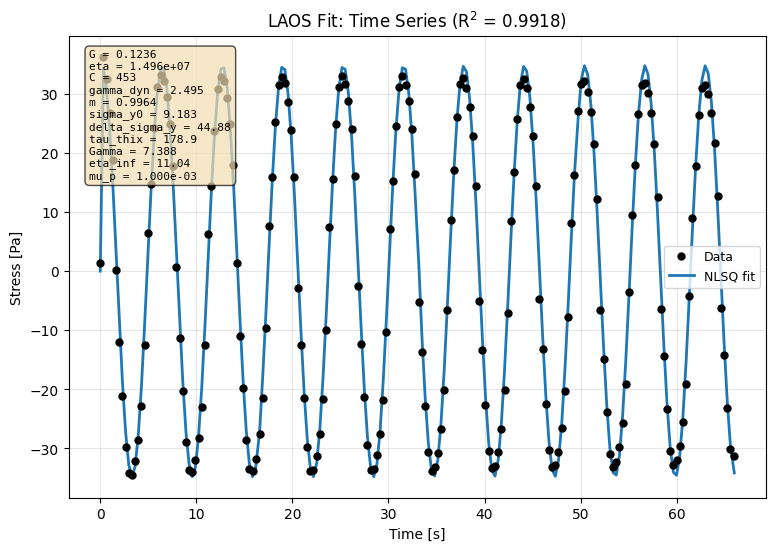

In [7]:
# Plot NLSQ fit with uncertainty band (LAOS: linear scale)
# Use x_pred=t_data to avoid generating a fine grid that doesn't match
# the time array structure required by the LAOS ODE solver.
fig, ax = plot_nlsq_fit(
    t_data, stress_data, model, test_mode="laos",
    param_names=param_names, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"LAOS Fit: Time Series (R$^2$ = {metrics['R2']:.4f})",
    x_pred=t_data,
    gamma_0=gamma_0, omega=omega,
)
display(fig)
plt.close(fig)

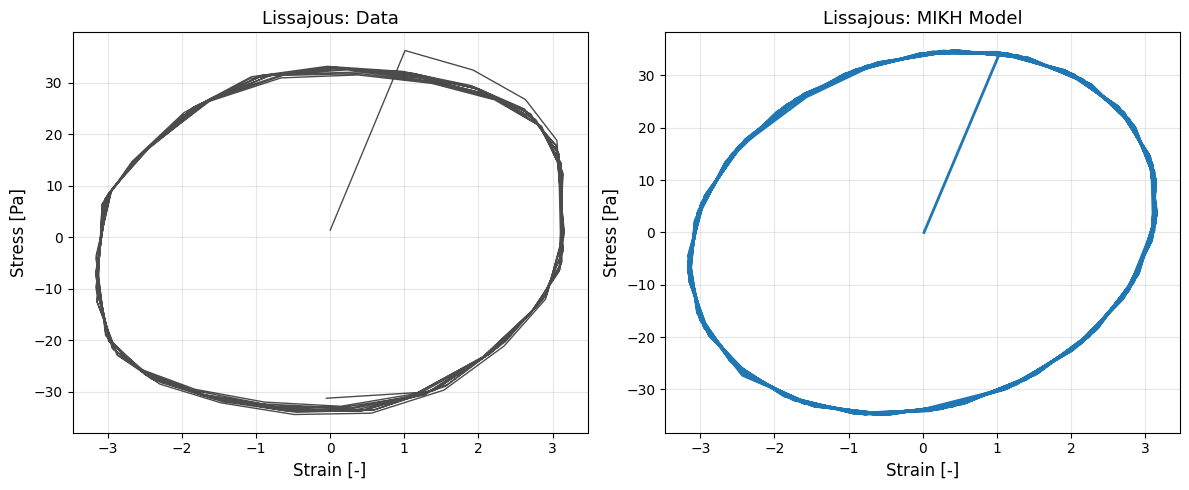

In [8]:
# Lissajous comparison
strain_pred = gamma_0 * np.sin(omega * np.array(t_data))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data Lissajous
ax1.plot(strain_data, stress_data, "k-", lw=1, alpha=0.7)
ax1.set_xlabel("Strain [-]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Lissajous: Data", fontsize=13)
ax1.grid(True, alpha=0.3)

# Model Lissajous
ax2.plot(strain_pred, stress_pred, "-", lw=2, color="C0")
ax2.set_xlabel("Strain [-]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Lissajous: MIKH Model", fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Harmonic Analysis

In [9]:
# Extract harmonics via FFT
def extract_harmonics(t, y, omega, n_harmonics=5):
    """Extract harmonic amplitudes from oscillatory signal."""
    n = len(y)
    dt = np.mean(np.diff(t))
    
    # FFT
    Y = rfft(y)
    freqs = rfftfreq(n, dt)
    
    # Find fundamental frequency index
    f0 = omega / (2 * np.pi)
    idx_f0 = np.argmin(np.abs(freqs - f0))
    
    # Extract harmonic amplitudes
    harmonics = {}
    for h in range(1, n_harmonics + 1):
        idx = idx_f0 * h
        if idx < len(Y):
            harmonics[h] = 2 * np.abs(Y[idx]) / n
        else:
            harmonics[h] = 0.0
    
    return harmonics

# Extract harmonics from data and model
harmonics_data = extract_harmonics(t_data, stress_data, omega)
harmonics_model = extract_harmonics(t_data, np.array(stress_pred), omega)

print("Harmonic Analysis:")
print(f"{'Harmonic':<10} {'Data [Pa]':>12} {'Model [Pa]':>12}")
print("-" * 36)
for h in range(1, 6):
    print(f"  I_{h:<6}    {harmonics_data.get(h, 0):12.3f}   {harmonics_model.get(h, 0):12.3f}")

# Third harmonic ratio (nonlinearity measure)
I3_I1_data = harmonics_data.get(3, 0) / harmonics_data.get(1, 1)
I3_I1_model = harmonics_model.get(3, 0) / harmonics_model.get(1, 1)
print(f"\nThird harmonic ratio I_3/I_1:")
print(f"  Data:  {I3_I1_data:.4f}")
print(f"  Model: {I3_I1_model:.4f}")

Harmonic Analysis:
Harmonic      Data [Pa]   Model [Pa]
------------------------------------
  I_1               24.963         24.930
  I_2                1.266          1.151
  I_3                0.242          0.690
  I_4                0.391          0.451
  I_5                0.395          0.325

Third harmonic ratio I_3/I_1:
  Data:  0.0097
  Model: 0.0277


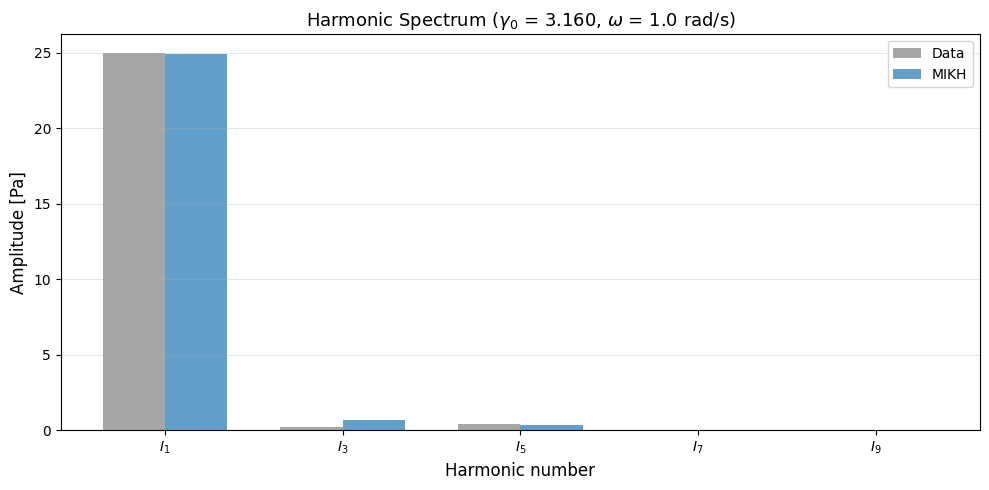

In [10]:
# Harmonic spectrum plot
fig, ax = plt.subplots(figsize=(10, 5))

harmonics = [1, 3, 5, 7, 9]
data_vals = [harmonics_data.get(h, 0) for h in harmonics]
model_vals = [harmonics_model.get(h, 0) for h in harmonics]

x = np.arange(len(harmonics))
width = 0.35

ax.bar(x - width/2, data_vals, width, label="Data", color="gray", alpha=0.7)
ax.bar(x + width/2, model_vals, width, label="MIKH", color="C0", alpha=0.7)

ax.set_ylabel("Amplitude [Pa]", fontsize=12)
ax.set_xlabel("Harmonic number", fontsize=12)
ax.set_title(f"Harmonic Spectrum ($\\gamma_0$ = {gamma_0:.3f}, $\\omega$ = {omega} rad/s)", fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([f"$I_{h}$" for h in harmonics])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Multi-Frequency Analysis

In [11]:
# Load LAOS at multiple frequencies (with fallback for missing data)
omega_values = [1.0, 3.0]  # omega=5.0 may not have data at all strain amplitudes
laos_datasets = {}

for w in omega_values:
    try:
        t, strain, stress = load_pnas_laos(omega=w, strain_amplitude_index=strain_amp_idx)
        if len(t) > 0 and len(strain) > 0:
            laos_datasets[w] = {"time": t, "strain": strain, "stress": stress}
            print(f"omega = {w} rad/s: {len(t)} points, gamma_0 ~ {np.max(np.abs(strain)):.3f}")
        else:
            print(f"omega = {w} rad/s: Empty data, skipping")
    except Exception as e:
        print(f"omega = {w} rad/s: Failed to load ({e})")

omega = 1.0 rad/s: 1000 points, gamma_0 ~ 3.160


omega = 3.0 rad/s: 1000 points, gamma_0 ~ 3.160


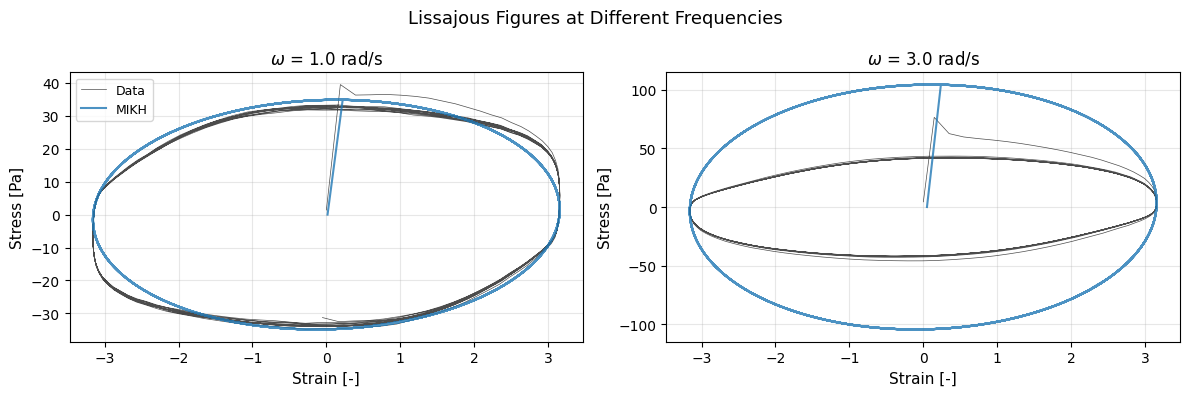

In [12]:
# Compare Lissajous figures at different frequencies
n_datasets = len(laos_datasets)
if n_datasets > 0:
    fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 4))
    if n_datasets == 1:
        axes = [axes]

    for i, w in enumerate(laos_datasets.keys()):
        d = laos_datasets[w]
        
        # Data
        axes[i].plot(d["strain"], d["stress"], "k-", lw=0.5, alpha=0.7, label="Data")
        
        # Model prediction
        gamma_0_w = np.max(np.abs(d["strain"]))
        stress_pred_w = model.predict(d["time"], test_mode="laos",  gamma_0=gamma_0_w,  omega=w)
        strain_pred_w = gamma_0_w * np.sin(w * np.array(d["time"]))
        axes[i].plot(strain_pred_w, stress_pred_w, "-", lw=1.5, color="C0", alpha=0.8, label="MIKH")
        
        axes[i].set_xlabel("Strain [-]", fontsize=11)
        axes[i].set_ylabel("Stress [Pa]", fontsize=11)
        axes[i].set_title(f"$\\omega$ = {w} rad/s", fontsize=12)
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend(fontsize=9)

    plt.suptitle("Lissajous Figures at Different Frequencies", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("No LAOS datasets available for multi-frequency comparison")

## 7. Bayesian Inference

In [13]:
# Clear JAX compilation caches and garbage before Bayesian inference
# to reduce peak memory for ODE-based LAOS NUTS sampling
import gc
gc.collect()
try:
    jax.clear_caches()
except Exception:
    pass

# Bayesian inference (reduced for time-domain LAOS)
initial_values = {name: model.parameters.get_value(name) for name in param_names}

# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 25
    NUM_SAMPLES = 50
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print("(Note: Time-domain LAOS inference is slow, using reduced samples)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="laos",
    gamma_0=gamma_0,
    omega=omega,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 25 warmup + 50 samples x 1 chain(s)
(Note: Time-domain LAOS inference is slow, using reduced samples)


  0%|          | 0/75 [00:00<?, ?it/s]

warmup:   1%|▏         | 1/75 [00:00<00:31,  2.32it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   5%|▌         | 4/75 [00:00<00:08,  8.71it/s, 255 steps of size 4.09e-03. acc. prob=0.22]

warmup:   8%|▊         | 6/75 [00:00<00:08,  8.57it/s, 255 steps of size 3.84e-03. acc. prob=0.47]

warmup:  11%|█         | 8/75 [00:01<00:07,  8.43it/s, 255 steps of size 5.51e-03. acc. prob=0.60]

warmup:  13%|█▎        | 10/75 [00:01<00:07,  8.37it/s, 255 steps of size 5.46e-03. acc. prob=0.66]

warmup:  15%|█▍        | 11/75 [00:01<00:07,  8.36it/s, 255 steps of size 7.46e-03. acc. prob=0.69]

warmup:  16%|█▌        | 12/75 [00:01<00:07,  8.34it/s, 255 steps of size 9.60e-03. acc. prob=0.72]

warmup:  17%|█▋        | 13/75 [00:01<00:07,  8.38it/s, 255 steps of size 1.34e-02. acc. prob=0.74]

warmup:  20%|██        | 15/75 [00:01<00:05, 10.37it/s, 255 steps of size 4.83e-03. acc. prob=0.74]

warmup:  23%|██▎       | 17/75 [00:01<00:06,  9.57it/s, 255 steps of size 8.82e-03. acc. prob=0.76]

warmup:  25%|██▌       | 19/75 [00:02<00:05, 10.92it/s, 31 steps of size 8.87e-04. acc. prob=0.74] 

warmup:  28%|██▊       | 21/75 [00:02<00:05,  9.97it/s, 255 steps of size 1.87e-03. acc. prob=0.76]

warmup:  31%|███       | 23/75 [00:02<00:05,  9.42it/s, 255 steps of size 3.71e-03. acc. prob=0.78]

warmup:  33%|███▎      | 25/75 [00:02<00:04, 10.41it/s, 63 steps of size 5.29e-02. acc. prob=0.80] 

sample:  37%|███▋      | 28/75 [00:02<00:03, 13.29it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  40%|████      | 30/75 [00:03<00:03, 14.10it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  43%|████▎     | 32/75 [00:03<00:02, 14.75it/s, 191 steps of size 5.29e-02. acc. prob=1.00]

sample:  45%|████▌     | 34/75 [00:03<00:02, 15.72it/s, 95 steps of size 5.29e-02. acc. prob=1.00] 

sample:  51%|█████     | 38/75 [00:03<00:01, 19.34it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  55%|█████▍    | 41/75 [00:03<00:01, 20.87it/s, 63 steps of size 5.29e-02. acc. prob=1.00] 

sample:  59%|█████▊    | 44/75 [00:03<00:01, 21.32it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  63%|██████▎   | 47/75 [00:03<00:01, 20.96it/s, 63 steps of size 5.29e-02. acc. prob=1.00] 

sample:  67%|██████▋   | 50/75 [00:03<00:01, 19.53it/s, 63 steps of size 5.29e-02. acc. prob=1.00]

sample:  72%|███████▏  | 54/75 [00:04<00:00, 23.12it/s, 63 steps of size 5.29e-02. acc. prob=1.00]

sample:  76%|███████▌  | 57/75 [00:04<00:00, 20.93it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  80%|████████  | 60/75 [00:04<00:00, 18.37it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  84%|████████▍ | 63/75 [00:04<00:00, 18.78it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  88%|████████▊ | 66/75 [00:04<00:00, 19.20it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample:  92%|█████████▏| 69/75 [00:04<00:00, 20.63it/s, 63 steps of size 5.29e-02. acc. prob=1.00] 

sample:  96%|█████████▌| 72/75 [00:05<00:00, 21.81it/s, 63 steps of size 5.29e-02. acc. prob=1.00]

sample: 100%|██████████| 75/75 [00:05<00:00, 23.48it/s, 127 steps of size 5.29e-02. acc. prob=1.00]

sample: 100%|██████████| 75/75 [00:05<00:00, 14.66it/s, 127 steps of size 5.29e-02. acc. prob=1.00]


Bayesian inference time: 7.6 s


In [14]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    0.9822        36     CHECK
            eta    0.9858        65     CHECK
              C    0.9806       101      PASS
      gamma_dyn    0.9915       123      PASS
              m    1.0586        10     CHECK
       sigma_y0    0.9842        54     CHECK
  delta_sigma_y    1.0106        67     CHECK
       tau_thix    1.0189        28     CHECK
          Gamma    0.9798        60     CHECK
        eta_inf    0.9843        50     CHECK
           mu_p    0.9807        72     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


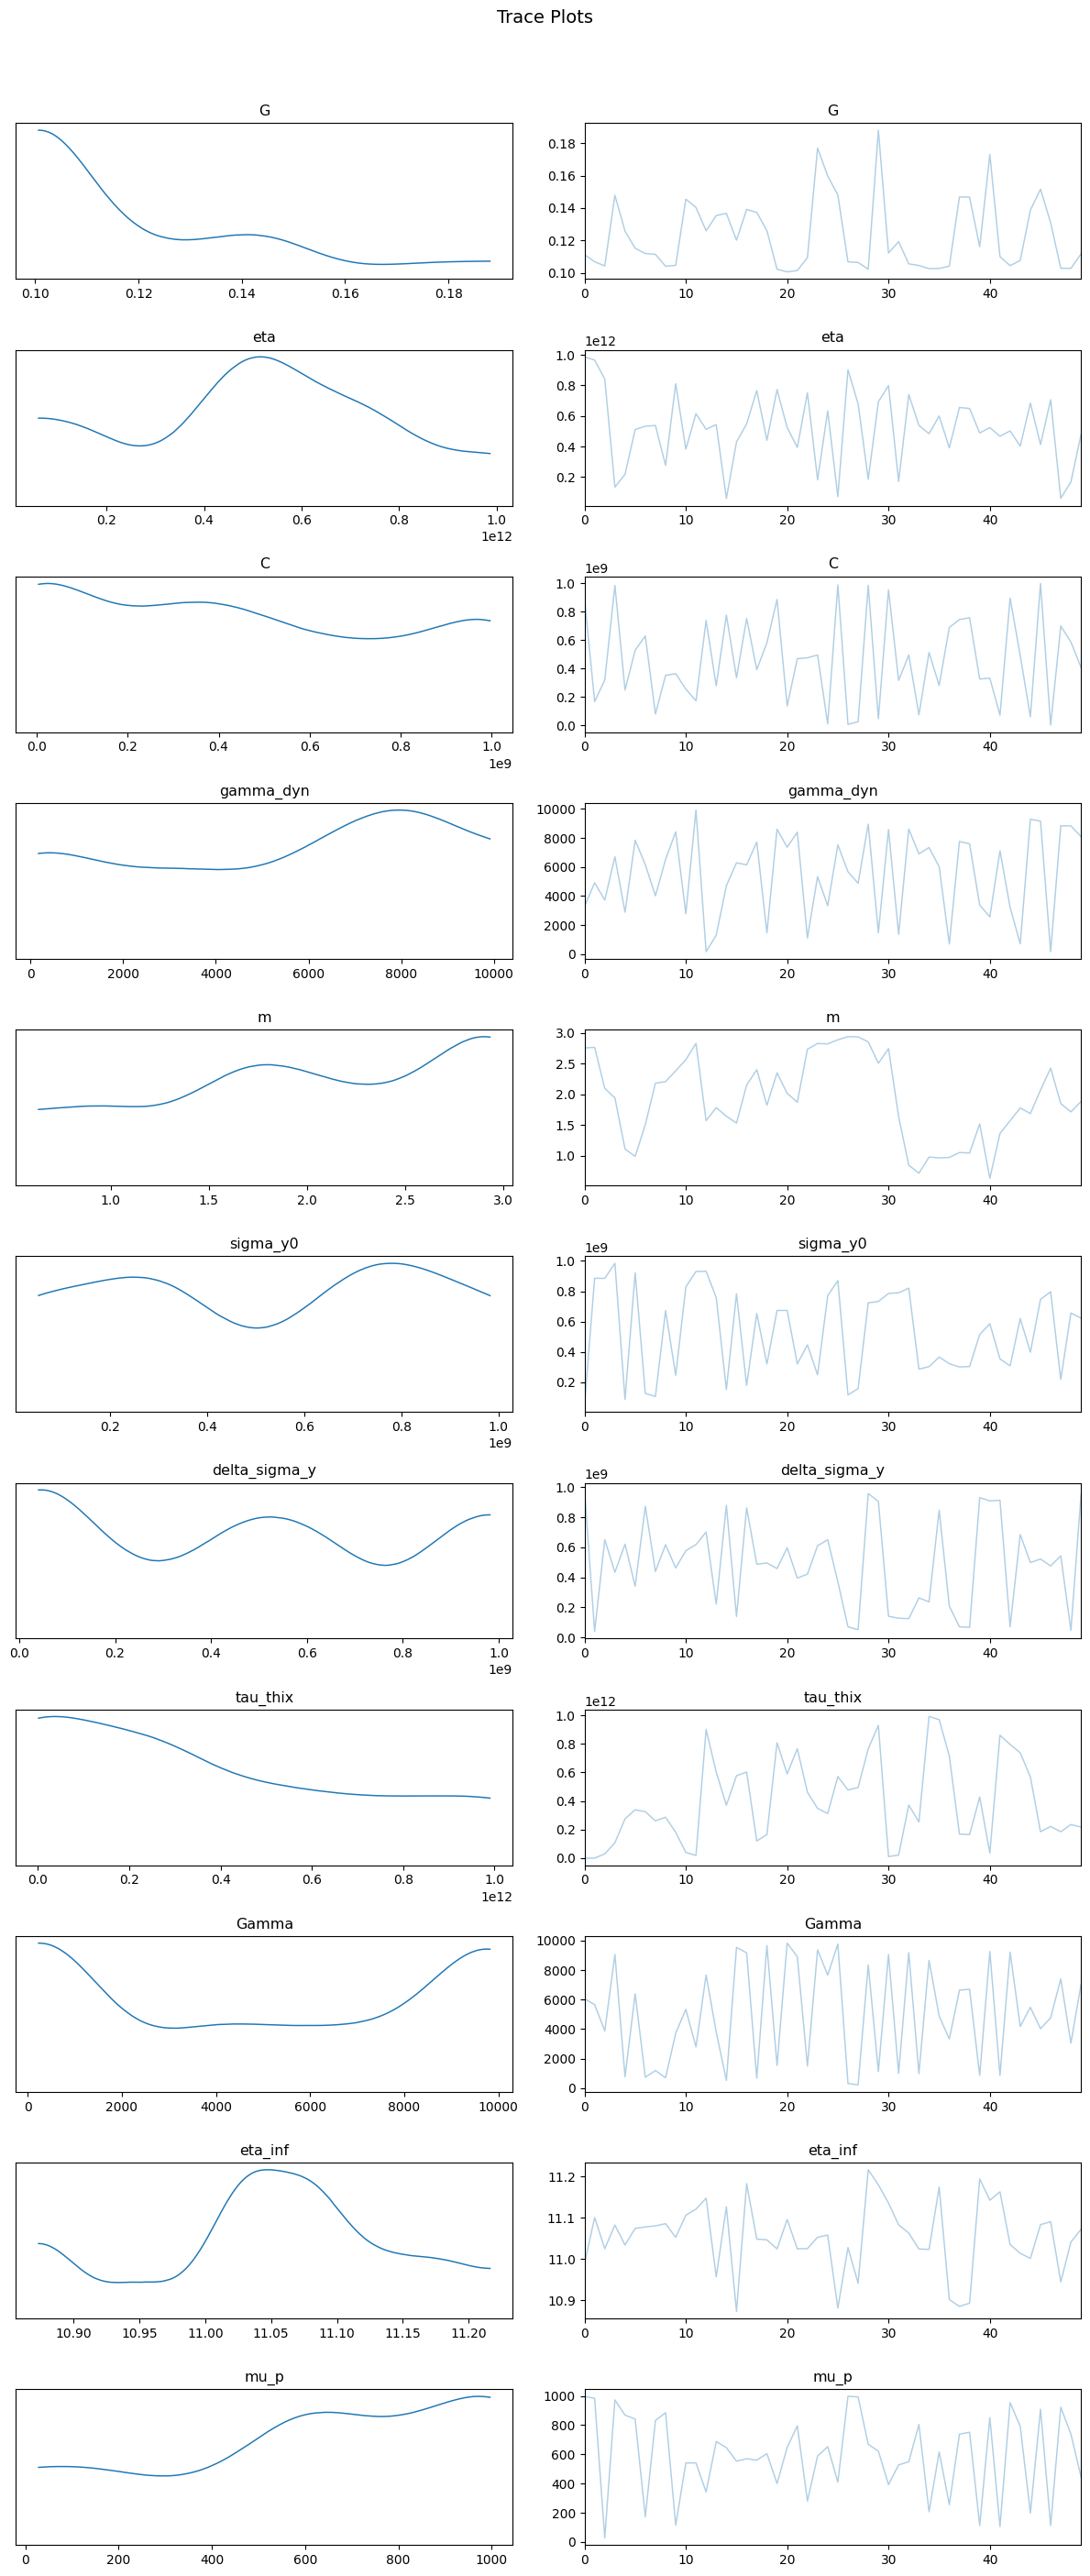

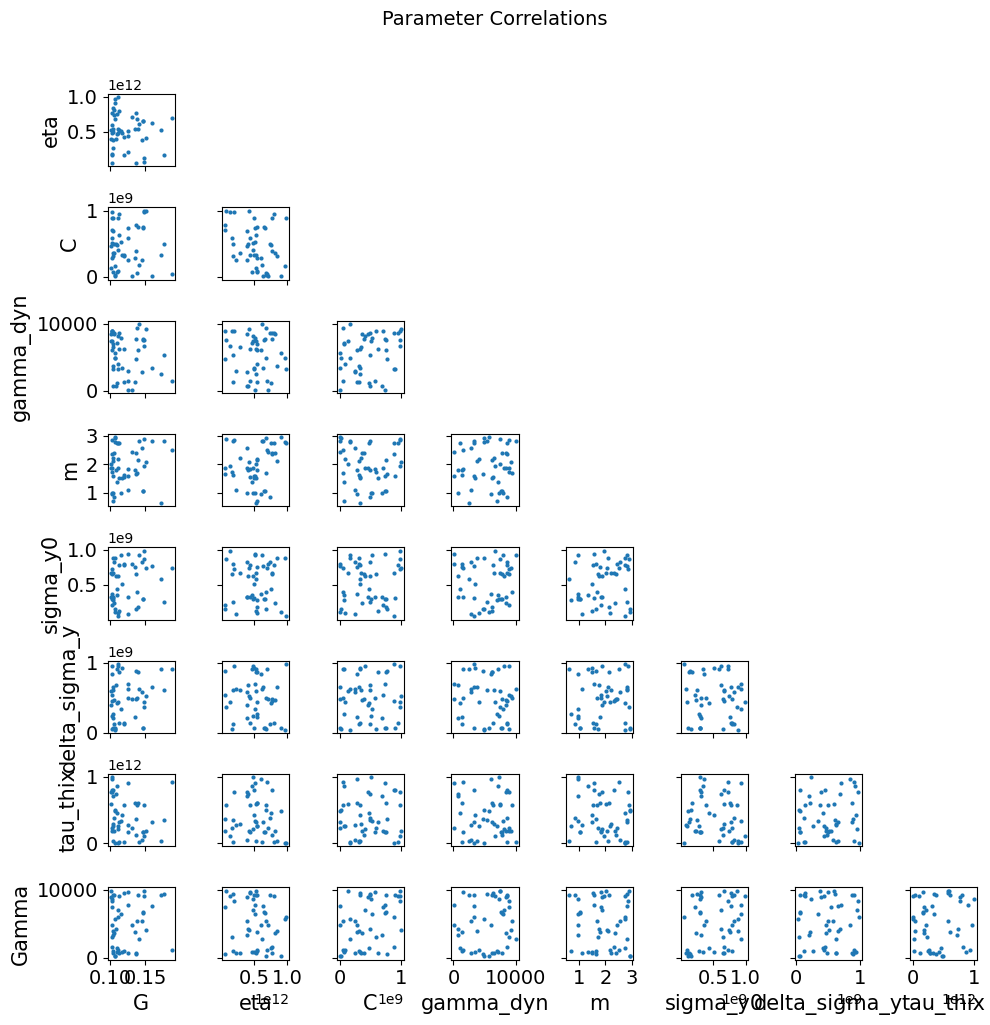

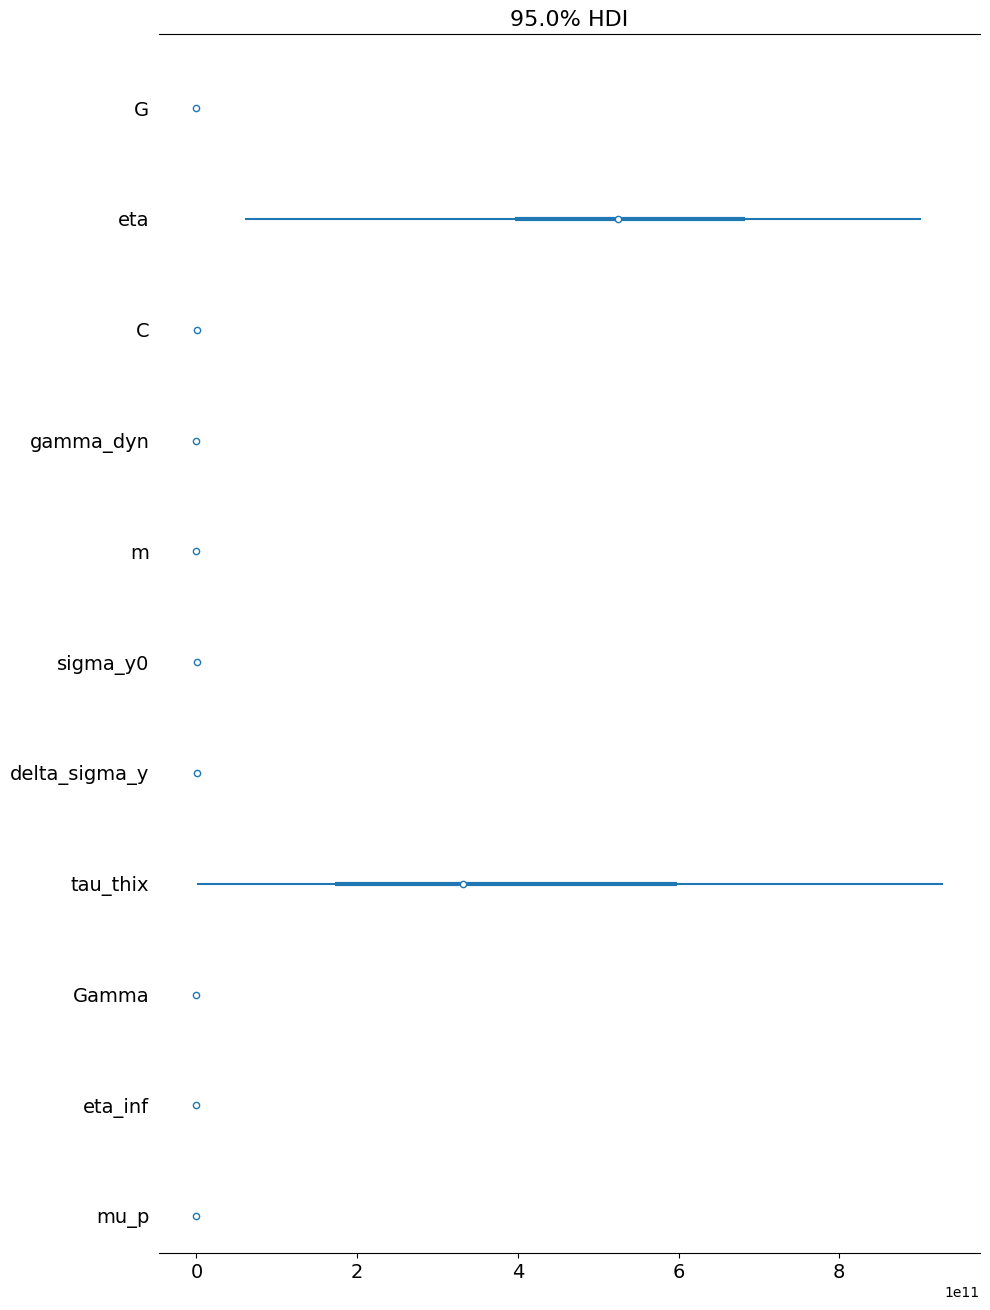

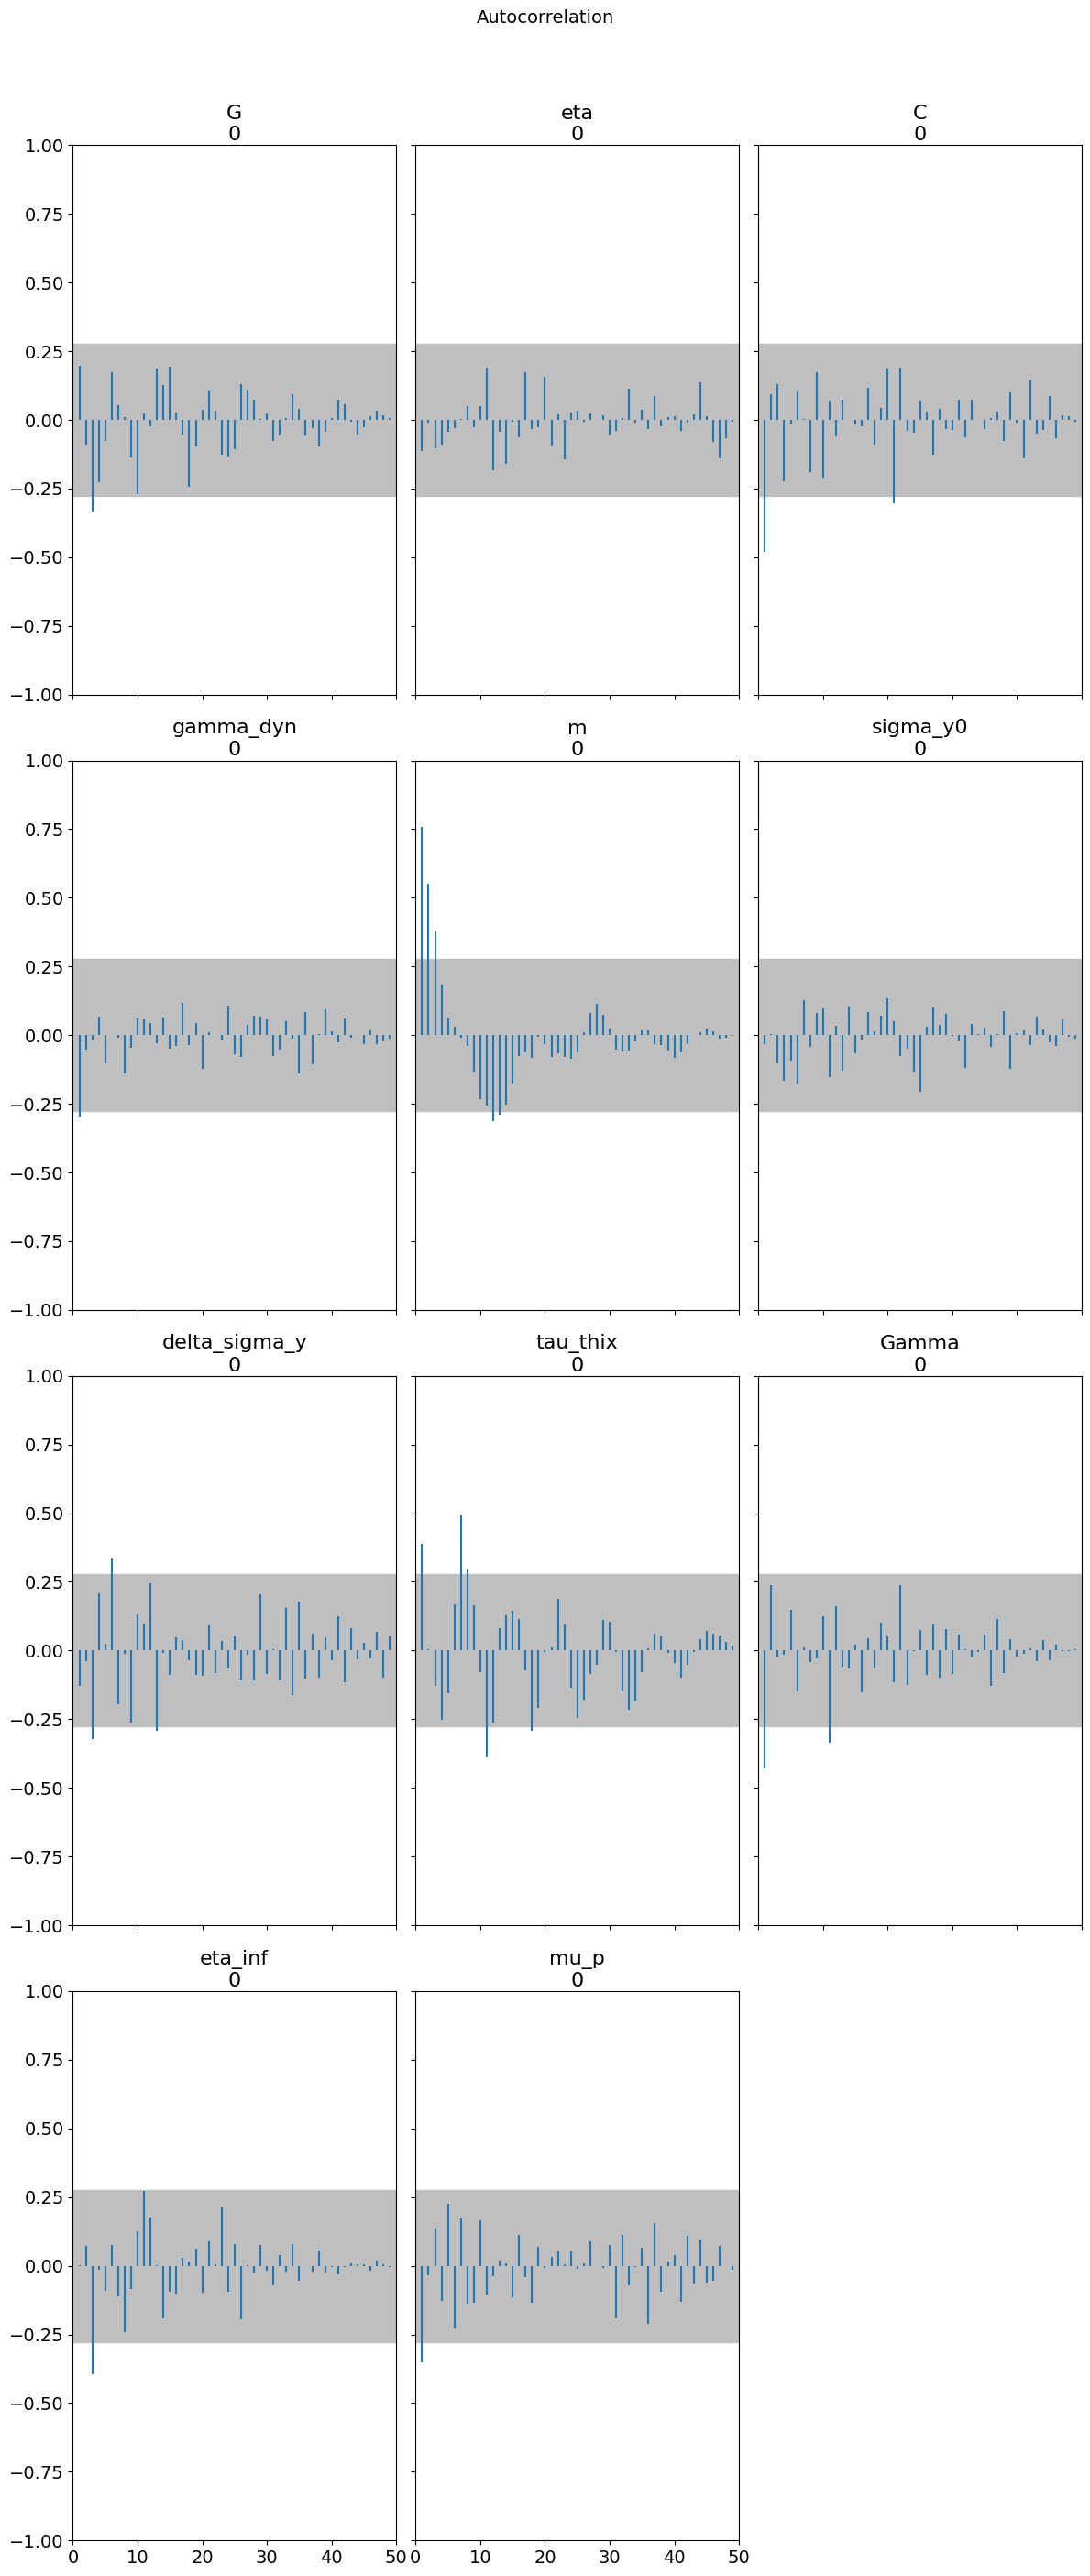

In [15]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [16]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G        0.1236        0.1121  [0.1015, 0.1762]
            eta     1.496e+07     5.243e+11  [6.352e+10, 9.516e+11]
              C           453     4.386e+08  [9.323e+06, 9.866e+08]
      gamma_dyn         2.495          6158  [290.7, 9263]
              m        0.9964         1.874  [0.7427, 2.922]
       sigma_y0         9.183     6.031e+08  [9.218e+07, 9.307e+08]
  delta_sigma_y         44.88     4.918e+08  [4.862e+07, 9.568e+08]
       tau_thix         178.9     3.321e+11  [3.124e+09, 9.598e+11]
          Gamma         7.388          5107  [355.4, 9747]
        eta_inf         11.04         11.06  [10.88, 11.19]
           mu_p         0.001         619.4  [107.1, 995.4]


## 8. Physical Interpretation

### Lissajous Shape Analysis

The shape of the Lissajous figure reveals the material character:

- **Narrow ellipse**: Elastic-dominated
- **Wide ellipse**: Viscous-dominated
- **Rectangular**: Yield stress dominated (rate-independent plasticity)
- **Parallelogram**: Kinematic hardening present

### Nonlinearity Sources in MIKH

1. **Plastic flow**: When $|\sigma - \alpha| > \sigma_y$, creates distortion
2. **Kinematic hardening**: Backstress $\alpha$ shifts yield surface during cycle
3. **Thixotropic dynamics**: Structure varies within cycle at low frequencies

### Frequency Dependence

- **Low frequency** ($\omega \ll 1/\tau_{thix}$): Full thixotropic restructuring within cycle
- **High frequency** ($\omega \gg 1/\tau_{thix}$): Structure frozen, pure elastoplastic response

## 9. Save Results

In [17]:
# Save results
save_ikh_results(model, result, "mikh", "laos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/laos/
  nlsq_params_laos.json: 11 parameters
  posterior_laos.json: 50 draws


## Key Takeaways

1. **LAOS** probes the nonlinear mechanical response of MIKH materials beyond the yield stress

2. **Lissajous figures** reveal the interplay of elasticity, viscosity, and plasticity

3. **Harmonic analysis** quantifies nonlinearity through $I_3/I_1$ and higher harmonics

4. **Kinematic hardening** ($C$, $\gamma_{dyn}$) creates asymmetry in the stress-strain loops

5. **Frequency dependence**: Low $\omega$ allows thixotropic restructuring; high $\omega$ freezes structure

6. The MIKH model captures the essential LAOS features through its elastoplastic + thixotropic framework

### Next Steps (MLIKH Notebooks)

- **NB07**: MLIKH Flow Curve (multi-mode thixotropic yield)
- **NB08**: MLIKH Startup (richer overshoot dynamics)
- **NB09-12**: MLIKH for remaining protocols

In [18]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
